# CITS5508 Assignment 3 - Gavin Pikes #

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, cut_tree
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.decomposition import PCA
from graphviz import Source

## 3.1 A model for diagnosing cancer ##
> **Task 1:** Build a logistic regression and a decision tree model to predict the tumour status. The presentation should include a comparison of the two models and a recommendation regarding which would be
more appropriate in a clinical setting. Note: You should use the fundamental steps of a machine learning
project (e.g. hyperparameters fine-tuning, cross-validation, etc.).

In [2]:
# Creating df from csv
data_file = 'breast-cancer.csv'
data = pd.read_csv(data_file)

# Check for any NaN values
nan_check = data.isnull().values.any() 
print("Are NaN values present in the data set?\n{}".format(nan_check))

# Create feature set
remove = ['id', 'diagnosis']
x = data.loc[:, ~data.columns.isin(remove)]

# Create target set and set malignant=1 & benign=0
y_cat = pd.DataFrame(data['diagnosis'])
y = pd.get_dummies(y_cat)
y = pd.DataFrame(y['diagnosis_M'])

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=123)

# Scaling the feature data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Converting the training and testing arrays to dataframes
x_train = pd.DataFrame(x_train_scaled, columns=list(x_train.columns))
y_train = pd.DataFrame(y_train, columns=list(y_train.columns))
x_test = pd.DataFrame(x_test_scaled, columns=list(x_test.columns))
y_test = pd.DataFrame(y_test, columns=list(y_test.columns))

print("Having a look at the feature data:")
x_train.head(5)

Are NaN values present in the data set?
False
Having a look at the feature data:


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,0.129063,1.852729,0.207702,0.023434,1.227427,1.029810,0.938829,0.635355,1.702483,1.073358
1,-0.587228,-0.327630,-0.647156,-0.593437,-1.390650,-1.248646,-1.096885,-1.115299,-1.533395,-0.324186
2,0.391607,0.024041,0.413547,0.284619,0.895488,0.326886,0.721909,0.821360,0.395484,-0.704451
3,-0.321829,-0.245951,-0.312088,-0.363850,-1.625126,-0.491491,-0.607573,-0.774728,0.195218,-0.561505
4,-0.230509,0.205549,-0.182037,-0.305873,0.535300,0.729367,0.118419,0.325091,0.546562,0.663948


Default logistic regression train accuracy: 0.944
Default logistic regression test accuracy: 0.953

Default decision tree train accuracy: 1.000
Default decision tree test accuracy: 0.895


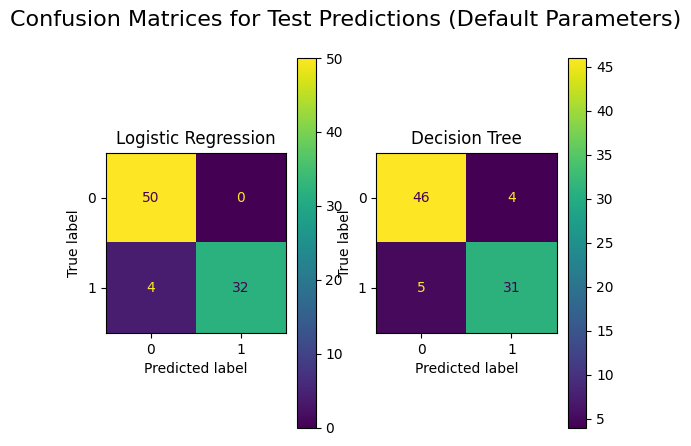

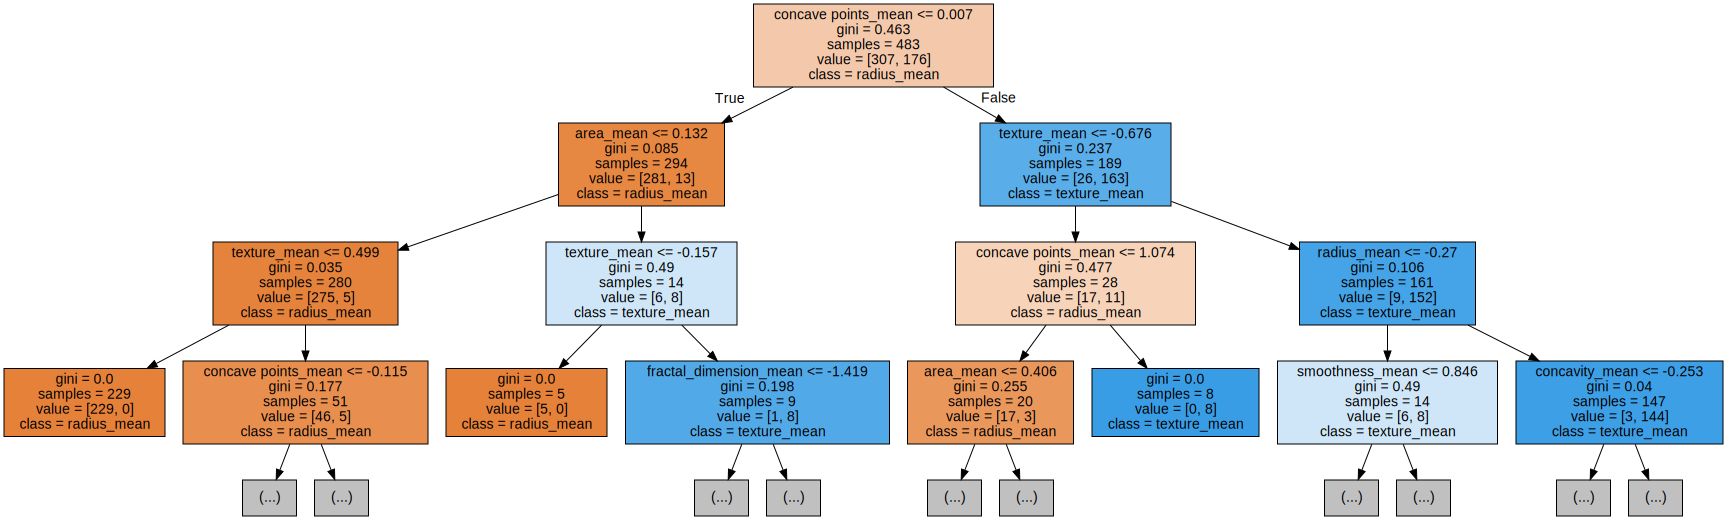

In [3]:
# Training default logistic regression model
logreg = LogisticRegression(random_state=123)
logreg.fit(x_train, y_train.values.ravel())

# Training and testing accuracy of default logistic regression model
logreg_pred_train = logreg.predict(x_train) # Train accuracy
logreg_acc_train = accuracy_score(y_train, logreg_pred_train)
print("Default logistic regression train accuracy: {:.3f}".format(logreg_acc_train))
logreg_pred_test = logreg.predict(x_test) # Test accuracy
logreg_acc_test = accuracy_score(y_test, logreg_pred_test)
print("Default logistic regression test accuracy: {:.3f}\n".format(logreg_acc_test))

# Training default decision tree model
dtc = DecisionTreeClassifier(random_state=123)
dtc.fit(x_train, y_train)

# Testing default decision tree model
dtc_pred_train = dtc.predict(x_train) # Train accuracy
dtc_acc_train = accuracy_score(y_train, dtc_pred_train)
print("Default decision tree train accuracy: {:.3f}".format(dtc_acc_train))
dtc_pred_test = dtc.predict(x_test) # Test accuracy
dtc_acc_test = accuracy_score(y_test, dtc_pred_test)
print("Default decision tree test accuracy: {:.3f}".format(dtc_acc_test))

# Confusion matrix of prediction
fig, axs = plt.subplots(1, 2)
fig.suptitle('Confusion Matrices for Test Predictions (Default Parameters)', fontsize=16)

# Logistic regression confusion matrix
logreg_cm = confusion_matrix(y_test, logreg_pred_test, labels=logreg.classes_)
disp_logreg_cm = ConfusionMatrixDisplay(confusion_matrix=logreg_cm, display_labels=logreg.classes_).plot(ax=axs[0])
axs[0].title.set_text("Logistic Regression")

# Decision tree confusion matrix
dtc_cm = confusion_matrix(y_test, dtc_pred_test, labels=dtc.classes_)
disp_dtc_cm = ConfusionMatrixDisplay(confusion_matrix=dtc_cm, display_labels=dtc.classes_).plot(ax=axs[1])
axs[1].title.set_text("Decision Tree")

plt.show()

# Plot decision tree diagram
export_graphviz(dtc, out_file="cancer_tree.dot", feature_names=x_train.columns, class_names=x_test.columns, 
                max_depth=3, filled=True)
Source.from_file("cancer_tree.dot")

Logistic regression tuned hyperparameter values are: {'C': 0.01, 'penalty': 'l2'}
Tuned logistic regression train accuracy: 0.932
Tuned logistic regression test accuracy: 0.953

Decision tree tuned hyperparameter values are: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 9}
Tuned decision tree train accuracy: 0.975
Tuned decision tree test accuracy: 0.907



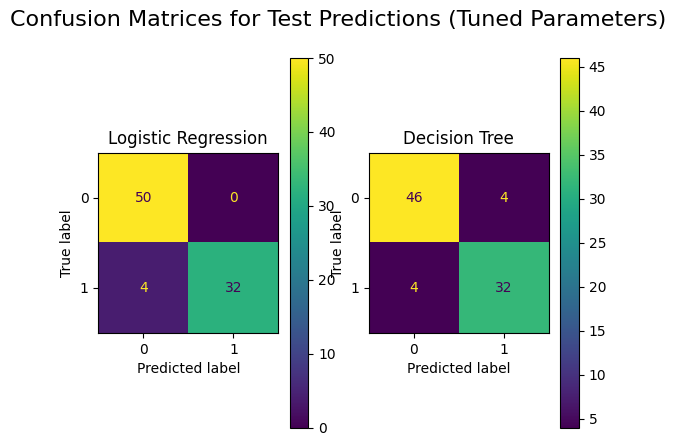

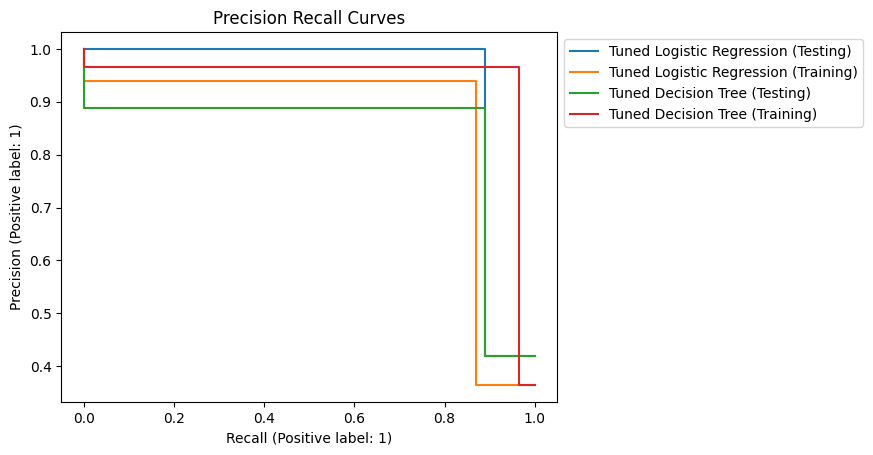

In [4]:
# Perform grid search on logistic regression model to determine best hyperparameters
param_logreg = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
tuned_logreg = LogisticRegression(solver='liblinear', random_state=123)
gs_logreg = GridSearchCV(estimator=tuned_logreg, param_grid=param_logreg, cv=3)
gs_logreg.fit(x_train, y_train.values.ravel())

# Return best hyperparameter values
tuned_logreg_params = gs_logreg.best_params_
print("Logistic regression tuned hyperparameter values are: {}".format(tuned_logreg_params))

# Return tuned accuracy scores
gs_logreg_pred_train = gs_logreg.predict(x_train) # Train accuracy
gs_logreg_acc_train = accuracy_score(y_train, gs_logreg_pred_train)
print("Tuned logistic regression train accuracy: {:.3f}".format(gs_logreg_acc_train))
gs_logreg_pred_test = gs_logreg.predict(x_test) # Test accuracy
gs_logreg_acc_test = accuracy_score(y_test, gs_logreg_pred_test)
print("Tuned logistic regression test accuracy: {:.3f}\n".format(gs_logreg_acc_test))

# Perform grid search on decision tree model to determine best hyperparameters
min_check = 2
max_check = 10
param_dtc = {'max_depth': range(min_check, max_check), 'min_samples_split': range(min_check, max_check), 
             'min_samples_leaf': range(min_check, max_check)}
tuned_dtc = DecisionTreeClassifier(random_state=123)
gs_dtc = GridSearchCV(estimator=tuned_dtc, param_grid=param_dtc, cv=3)
gs_dtc.fit(x_train, y_train.values.ravel())

# Return best hyperparameter values
tuned_dtc_params = gs_dtc.best_params_
print("Decision tree tuned hyperparameter values are: {}".format(tuned_dtc_params))

# Return tuned accuracy scores
gs_dtc_pred_train = gs_dtc.predict(x_train) # Train accuracy
gs_dtc_acc_train = accuracy_score(y_train, gs_dtc_pred_train)
print("Tuned decision tree train accuracy: {:.3f}".format(gs_dtc_acc_train))
gs_dtc_pred_test = gs_dtc.predict(x_test) # Test accuracy
gs_dtc_acc_test = accuracy_score(y_test, gs_dtc_pred_test)
print("Tuned decision tree test accuracy: {:.3f}\n".format(gs_dtc_acc_test))

# Confusion matrix of prediction
fig, axs = plt.subplots(1, 2)
fig.suptitle('Confusion Matrices for Test Predictions (Tuned Parameters)', fontsize=16)

# Logistic regression confusion matrix
gs_logreg_cm = confusion_matrix(y_test, gs_logreg_pred_test, labels=gs_logreg.classes_)
disp_gs_logreg_cm = ConfusionMatrixDisplay(confusion_matrix=gs_logreg_cm, display_labels=gs_logreg.classes_).plot(ax=axs[0])
axs[0].title.set_text("Logistic Regression")

# Decision tree confusion matrix
gs_dtc_cm = confusion_matrix(y_test, gs_dtc_pred_test, labels=gs_dtc.classes_)
disp_gs_dtc_cm = ConfusionMatrixDisplay(confusion_matrix=gs_dtc_cm, display_labels=gs_dtc.classes_).plot(ax=axs[1])
axs[1].title.set_text("Decision Tree")

plt.show()

# Plotting precision recall curves
fig2, axs2 = plt.subplots()
prc_logreg_test = PrecisionRecallDisplay.from_predictions(y_test, gs_logreg_pred_test,
                                                          label="Tuned Logistic Regression (Testing)", ax=axs2)
prc_logreg_train = PrecisionRecallDisplay.from_predictions(y_train, gs_logreg_pred_train,
                                                          label="Tuned Logistic Regression (Training)", ax=axs2)
prc_dtc_test = PrecisionRecallDisplay.from_predictions(y_test, gs_dtc_pred_test,
                                                       label="Tuned Decision Tree (Testing)", ax=axs2)
prc_dtc_train = PrecisionRecallDisplay.from_predictions(y_train, gs_dtc_pred_train,
                                                       label="Tuned Decision Tree (Training)", ax=axs2)
axs2.title.set_text("Precision Recall Curves")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

The data has first been loaded in and split into x and y features and train and test sets. The feature sets have then been standard scaled to ensure the difference in scales between the features does not effect the logistic regression (sensitive to scale due to large scales dominating feature coefficient estimates). Decision trees are not sensitive to scale as they split the data based off relative values one at a time, but should not suffer from the data being scaled.

Logistic regression and decision tree models have then been fitted using the training data and tested against both the training and testing scores. The logistic regression model appears to initially underfit the training data, providing higher accuracy scores on the testing set than the training set (although only very slightly). The similarity between the scores would indicate the model does not underfit drastically, instead being a reasonably good model to begin with. The decision tree model appears to overfit quite drastically, however. It shows perfect accuracy on the training set and only 90% accuracy on the testing set, indicated tuning of hyperparameters is required in order to reduce the degree of overfitting. Initially, at least, the logistic regression model appears better, showing more similar training and testing scores, as well half the number of errors in testing.

Looking at the initial confusion matrices, we see that the logistic regression model has 50 true negatives, while the decision tree only has 46. It also has 32 true positives, while the decision tree has 31. The major difference comes in the number of false positives, where the logistic regression shows none, while the decision tree shows 4. The logistic regression model also shows 4 false positives, while the decision tree shows 5.

The initial decision tree diagram also indicates a fair degree of overfitting, with almost half the nodes at a depth of 3 showing a gini score of 0, which would not be initally expected for a model that was applying a simpler classification algorithm. This overfitting would again be expected due to the small training set size, which would make the model prone to overfitting and not generalising to the data properly.

After hyperparameter tuning, the training accuracy of the logistic regression model actually drops, while the testing accuracy remains the same. The tuned model providing worse training accuracy would not typically be expected, but does make some sense in this case due to the low number of instances used in training and then the use of 3 fold cross validation further dropping the instances used in the training of each fold. 

The tuned decision tree model shows a lower training accuracy and higher testing accuracy, indicating the degree of overfitting has been lessened. The model does still appear to be overfitting, however, as there is still quite a reasonable separation between the accuracies displayed on the training and testing data. The depth was lessend, the minimum samples leaf increased and the minimum samples split increased in order to promote a more generalised decision making process that will not result in quite as much overfitting.

Looking at the confusion matrices produced, it can be seen that the tuned logistic regression confusion matrix remains unchanged. This is to be expected as the accuracy score on the testing set (from which the confusion matrix is developed) also remains unchanged. More difference can be seen in the tuned decision tree confusion matrix, however, where one of the false negatives has now become a true positive. Although only a minor improvement, this would again be expected as there was a slight increase in the testing accuracy of the decision tree.

Looking at the precision recall curves, it can be seen that the logistic regression model typically displays a higher precision while the decision tree typically displays a higher recall. 

> - **Task 2:** Describe the features that have a higher chance of impacting the prediction of the tumour status
according to each of the two models. Discuss their similarities/differences.

In [5]:
# Set tuned models
tuned_logreg = gs_logreg.best_estimator_
tuned_dtc = gs_dtc.best_estimator_

def feat_coefficients_logreg(model, x_features):
    """ Return feature coefficients for logistic regression """
    feat_coef = model.coef_ # Coefficients of all features
    x_feat = list(x_features.columns) # Feature names
    print("Feature coefficients for logistic regression:")
    index = 0
    while index < len(feat_coef[0]): # Print all feature coefficients
        print("{}: {:.3f}".format(x_feat[index], feat_coef[0][index]))
        index += 1

def feat_importances_dtc(model, x_features):
    """ Return feature importances for decision tree"""
    feat_imp = list(model.feature_importances_) # Importances of all features
    x_feat = list(x_features.columns) # Feature names
    print("\nFeature importances for decision tree:")
    index = 0
    while index < len(feat_imp): # Print all feature importances
        print("{}: {:.3f}".format(x_feat[index], feat_imp[index]))
        index += 1

# Return feature coefficients/importances
feat_coefficients_logreg(tuned_logreg, x_train)
feat_importances_dtc(tuned_dtc, x_train)

Feature coefficients for logistic regression:
radius_mean: 0.359
texture_mean: 0.288
perimeter_mean: 0.360
area_mean: 0.353
smoothness_mean: 0.163
compactness_mean: 0.233
concavity_mean: 0.310
concave points_mean: 0.381
symmetry_mean: 0.146
fractal_dimension_mean: -0.065

Feature importances for decision tree:
radius_mean: 0.021
texture_mean: 0.101
perimeter_mean: 0.003
area_mean: 0.039
smoothness_mean: 0.038
compactness_mean: 0.000
concavity_mean: 0.003
concave points_mean: 0.794
symmetry_mean: 0.002
fractal_dimension_mean: 0.000


Looking at the feature importances for the decision tree, it can be seen that there are just a few features that dominate the total importance. The concave points mean provides almost 80% of the importance, with the texture mean providing another 10%. The remaining 10% importance is spread over the remaining features, except for the compactness mean and fractal dimension mean features, which provides 0 importance. Hence, 90% feature importance can be retained using just the concave points mean and texture mean features.

Looking at the feature coefficients for logistic regression, it can be seen that no features dominate to nearly the same degree as seen in the decision tree. The concave mean, texture mean, radius mean, perimeter mean, area mean and concavity mean all show coefficients of approximately 0.3 or greater. The only feature that could be reasonably safely removed is the fractal dimesion mean, which shows a coefficient of -0.065. The logistic regression model hence uses a much larger number of the features, with none having a signficantly different magnitude than the rest (aside from fractal dimension mean which is substantially lower than any other feature). 

Hence, both models would class the fractal dimension mean feature as being insignificant and the concave points mean and texture mean as being features of significance, but the logistic regression model would assign a greater weight to the remaining features than the decision tree.

> - **Task 3:** Using PCA, present the scatter plot of the data on the first two principal components. Add
to your scatter plot different colours to represent the two classes in the data. What proportion of data
variance is explained using the first two principal components?

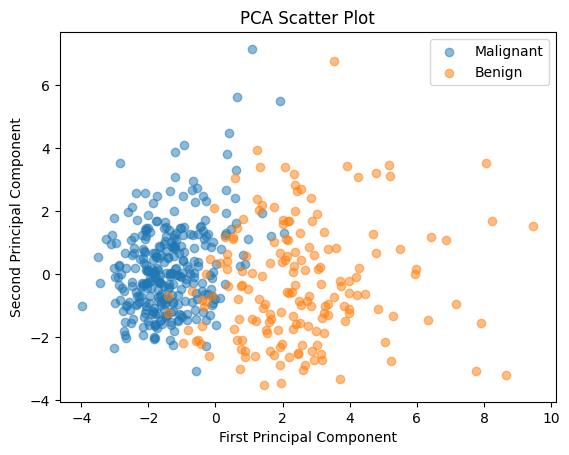

Proportion of variance explained by PC1: 0.547
Proportion of variance explained by PC2: 0.254


In [6]:
# Perform PCA fit and transform
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train)

# Separate into first and second principal components
PC1 = x_pca[:,0]
PC2 = x_pca[:,1]

# Form database of principal components and their labels
zipped = list(zip(PC1, PC2, y_train.values.ravel()))
pc_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'Target'])

# Split into benign and malignant portions of principal components
PC1_m = pc_df.loc[pc_df["Target"] == 0, "PC1"]
PC2_m = pc_df.loc[pc_df["Target"] == 0, "PC2"]
PC1_b = pc_df.loc[pc_df["Target"] == 1, "PC1"]
PC2_b = pc_df.loc[pc_df["Target"] == 1, "PC2"]

# Produce PCA scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(PC1_m, PC2_m, label="Malignant", alpha=0.5)
ax.scatter(PC1_b, PC2_b, label="Benign", alpha=0.5)
ax.legend()
plt.title("PCA Scatter Plot")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Determine proportion of explained variance for the 2 principal components
test = pca.explained_variance_ratio_
print("Proportion of variance explained by PC1: {:.3f}".format(test[0]))
print("Proportion of variance explained by PC2: {:.3f}".format(test[1]))

Principal component analysis has been performed on the scaled data and the first 2 principal components kept. The feature data has then been fitted and transformed to the PCA model and the 2 principal components plotted against each other and coloured by tumour status.

Looking at the PCA scatter plot, it can be seen that the two clusters can primarily be separated by their first principal component values. Although there is a degree of overlap, the malignant tumours typically exist for first principal values of less than zero and benign tumours typically exist in the region of values greater than zero. Interestingly, the malignant cluster shows a denser adn generally more spherical shape (if excluding some of the very high second principal component value instances).

Looking at the proportion of variance explained, 55% is explained by the first principal component and an additional 25% explained by the second. This gives a total explained variance of 80% for the first two principal components, indicating these two components alone can explain quite a large proportion of the variance, especially considering there are up to 10 principal components possible (minimum of number of features or instances).

> - **Task 4:** Considering the first two principal components from Task 3, present the biplot with the variables
vectors and the observed data projected on the first two principal components (with the colours for the
two categories). Give your interpretation of the results.

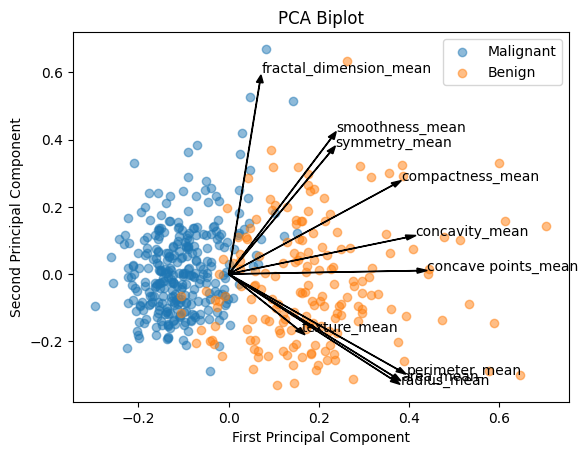

In [7]:
# Find pca components
pca_comp = pca.components_
x_feat = list(x_train.columns)

# Set scale of principal components
PC1_scale = 1 / (max(PC1) - min(PC1))
PC2_scale = 1 / (max(PC2) - min(PC2))

# Set fig/axs
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot scatter component
ax.scatter(PC1_m * PC1_scale, PC2_m * PC2_scale, label="Malignant", alpha=0.5)
ax.scatter(PC1_b * PC1_scale, PC2_b * PC2_scale, label="Benign", alpha=0.5)

# Plot variable vectors component
index = 0
while index < len(pca_comp[0]):
    ax.arrow(0, 0, pca_comp[0, index], pca_comp[1, index], head_width=0.015, color="black")
    ax.text(pca_comp[0, index] * 1.05, pca_comp[1, index] * 1.05, x_feat[index])
    index += 1

# Add plot features
ax.legend()
plt.title("PCA Biplot")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

The principal component values have first been scaled by the min/max values to ensure that they are on the same scale as the variable vectors component of the biplot. 

We can see by projecting the variable vectors onto the PCA scatter plot the impact of the different features. The length of the vectors corresponds to how much variance they explain and their angle corresponds to the relevance they have to the different principal components. A variable vector that aligns just with the positive first principal component axis shows a positive correlation to the first principal component and none to the second. A variable vector that shows a 135 degree angle shows an equal contribution to a positive second principal component coefficient and negative first principal component coefficient.

Looking at the biplot, we can then see that all features have a positive correlation to the first principal component (from their horizontal components), with the fractal dimension mean showing an extremely weak correlation; the smoothness mean, symmetry mean and texture mean showing a moderate correlation; and the compactness mean, concavity mean, concave points mean, perimeter mean, radius mean and area mean showing a much stronger correlation. As the first principal component appears to be the main factor influencing tumour status, the correlation between the features and the second principal component is of little interest or use.

> - **Task 5:** Using the plot of Task 4, which variables are more related to the tumour status? Justify your
answer. Compare the results obtained with the results obtained in Task 2.

The importance of the features can be seen in the biplot by the length of the variable vectors, with longer vectors correlating to explaining a higher proportion of the variance. Hence, it can be see that all the variables are of relatively similar importance in explaining variance, except for the texture mean variable, which is shown to be about half as important as any other variable. To then relate that to the tumour status, it can be seen that the tumour classification is primarily based off the value of the first principal component, so the correlation of the variable vectors to the first principal component then becomes significant. This is shown by the angle of the vectors, with vectors pointing in a similar direction being positively correlated and those pointing in the opposite direction being negatively correlated. From this, it can be seen that our most significant features in terms of correlation to the first principal component, and hence tumour status, are the concave points mean, concavity mean, perimeter mean, radius mean, area mean and compactness mean. The smoothness mean, symmetry mean and texture mean all show a reduced, but still relevant correlation, while the fractal dimension mean shows very little correlation whatsoever to the first principal component.

In comparison to task 2, these results are reasonably similar to the coefficients found for the logistic regression model, although the logistic regression model put more emphasis on the texture mean and less on the compactness mean. The decision tree results are obviously quite different, where the decision tree put 90% of its importance on just the concave points mean and texture mean. It would appear that the decision tree used the concave points mean feature to represent the vast majority of the importance represented on the biplot by the concave points mean, concavity mean, perimeter mean, radius mean, area mean and compactness mean. It also seems that the decision tree assigned most of the importance shown on the biplot by the texture mean, smoothness mean and symmetry mean to just the texture mean feature. This is mostly to be expected, as these values tend to share a reasonably similar first principal component on their variable vectors, so all the variable vectors could essentially be split into 3 groups showing no importance, moderate importance and high importance. The decision tree would be able to get reasonably good results by using just 1 feature from each of the 2 latter groups to classify the tumour status of the instances, which would explain why the decision tree gains most of its importance by the 2 features it does.

> - **Task 6:** Using PCA, determine the number of components to retain 95% of the explained variance. Use
as new features the resulting principal components scores and repeat task 1 on these new features. You
can choose one of the models (logistic regression or the decision tree). What is the dimension of the
new (projected) data set? Comment on the performance resulting from using the original and principal
components features.

Number of components required to provide >= 95% explained variance is 5, giving 97.51% explained variance.

Default PCA logistic regression train accuracy: 0.928
Default PCA logistic regression test accuracy: 0.953

PCA Logistic regression tuned hyperparameter values are: {'C': 0.01, 'penalty': 'l2'}
Tuned PCA logistic regression train accuracy: 0.932
Tuned PCA logistic regression test accuracy: 0.953



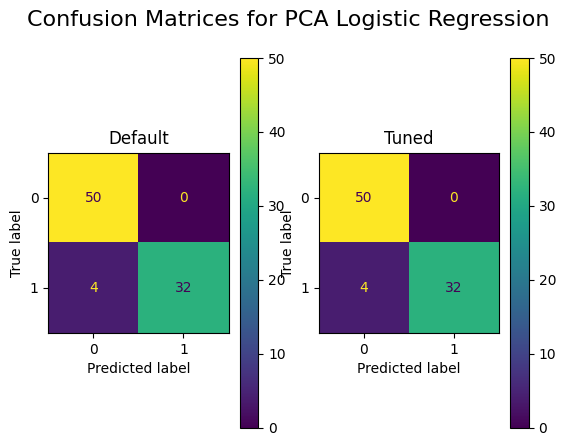

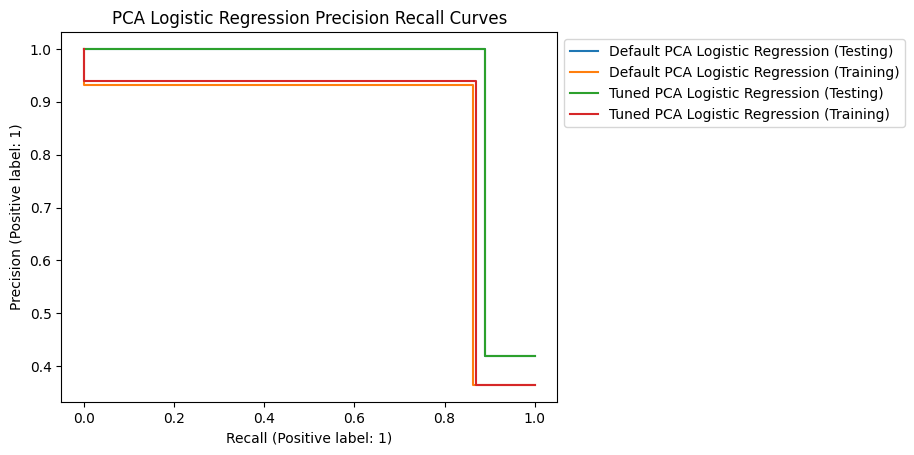

In [8]:
# PCA for 95% explained variance and fit/transform training/testing data
pca_95 = PCA(n_components=0.95)
x_train_pca = pca_95.fit_transform(x_train)
x_test_pca = pca_95.transform(x_test)

# Determine number of components necessary
pca_length = len(x_train_pca[0])
pca_explained = pca_95.explained_variance_ratio_
pca_percent = sum(pca_explained) * 100
print("Number of components required to provide >= 95% explained variance is {}, giving {:.2f}% explained variance.\n"
      .format(pca_length, pca_percent))

# Training default logistic regression model
logreg_pca = LogisticRegression(random_state=123)
logreg_pca.fit(x_train_pca, y_train.values.ravel())

# Training and testing accuracy of default logistic regression model
logreg_pca_pred_train = logreg_pca.predict(x_train_pca) # Train accuracy
logreg_pca_acc_train = accuracy_score(y_train, logreg_pca_pred_train)
print("Default PCA logistic regression train accuracy: {:.3f}".format(logreg_pca_acc_train))
logreg_pca_pred_test = logreg_pca.predict(x_test_pca) # Test accuracy
logreg_pca_acc_test = accuracy_score(y_test, logreg_pca_pred_test)
print("Default PCA logistic regression test accuracy: {:.3f}\n".format(logreg_pca_acc_test))

# Perform grid search on logistic regression model to determine best hyperparameters
param_logreg_pca = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
tuned_logreg_pca = LogisticRegression(solver='liblinear', random_state=123)
gs_logreg_pca = GridSearchCV(estimator=tuned_logreg_pca, param_grid=param_logreg_pca, cv=3)
gs_logreg_pca.fit(x_train_pca, y_train.values.ravel())

# Return best hyperparameter values
tuned_logreg_pca_params = gs_logreg_pca.best_params_
print("PCA Logistic regression tuned hyperparameter values are: {}".format(tuned_logreg_pca_params))

# Return tuned accuracy scores
gs_logreg_pca_pred_train = gs_logreg_pca.predict(x_train_pca) # Train accuracy
gs_logreg_pca_acc_train = accuracy_score(y_train, gs_logreg_pca_pred_train)
print("Tuned PCA logistic regression train accuracy: {:.3f}".format(gs_logreg_pca_acc_train))
gs_logreg_pca_pred_test = gs_logreg_pca.predict(x_test_pca) # Test accuracy
gs_logreg_pca_acc_test = accuracy_score(y_test, gs_logreg_pca_pred_test)
print("Tuned PCA logistic regression test accuracy: {:.3f}\n".format(gs_logreg_pca_acc_test))

# Confusion matrix of prediction
fig, axs = plt.subplots(1, 2)
fig.suptitle('Confusion Matrices for PCA Logistic Regression', fontsize=16)

# Logistic regression confusion matrix
logreg_pca_cm = confusion_matrix(y_test, logreg_pca_pred_test, labels=logreg_pca.classes_)
disp_logreg_pca_cm = ConfusionMatrixDisplay(confusion_matrix=logreg_pca_cm, display_labels=logreg_pca.classes_).plot(ax=axs[0])
axs[0].title.set_text("Default")

# Decision tree confusion matrix
gs_logreg_pca_cm = confusion_matrix(y_test, gs_logreg_pca_pred_test, labels=gs_logreg_pca.classes_)
disp_gs_logreg_pca_cm = ConfusionMatrixDisplay(confusion_matrix=gs_logreg_pca_cm, display_labels=gs_logreg_pca.classes_).plot(ax=axs[1])
axs[1].title.set_text("Tuned")

plt.show()

# Plotting precision recall curves
fig2, axs2 = plt.subplots()
prc_logreg_pca_test = PrecisionRecallDisplay.from_predictions(y_test, logreg_pca_pred_test,
                                                          label="Default PCA Logistic Regression (Testing)", ax=axs2)
prc_logreg_pca_train = PrecisionRecallDisplay.from_predictions(y_train, logreg_pca_pred_train,
                                                          label="Default PCA Logistic Regression (Training)", ax=axs2)
gs_prc_logreg_pca_test = PrecisionRecallDisplay.from_predictions(y_test, gs_logreg_pca_pred_test,
                                                          label="Tuned PCA Logistic Regression (Testing)", ax=axs2)
gs_prc_logreg_pca_train = PrecisionRecallDisplay.from_predictions(y_train, gs_logreg_pca_pred_train,
                                                          label="Tuned PCA Logistic Regression (Training)", ax=axs2)
axs2.title.set_text("PCA Logistic Regression Precision Recall Curves")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

PCA is first performed with a 95% explained variance retention threshold, which is achieved using 5 principal components that account for 97.5%. This means that we have been able to reduce the dimension of the model by half. A logistic regression model (chosen as it performed better in terms of testing accuracy in task 1, which would be of higher real world importance) is then fitted to the training data produced by the PCA model. Accuracy scores are then taken in terms of both training and testing accuracy. It can be seen that the training model has an accuracy of 92.8% as compared to the previous 94.4% of the untuned logistic regression model in task 1, and a testing accuracy of 95.3% which is equivalent to the previous testing accuracy. This slightly lower training accuracy is to be expected, as we have lost a small proportion of the variance in the switch to PCA. There has clearly not been too high a loss in variance to decrease the testing accuracy, however. Tuning the model, we are then able to increase the training accuracy to 93.2%, while the testing accuracy remains unchanged. 

Looking at the confusion matrices, we can see that both the tuned and untuned models produce the same confusion matrix, which is to be expected given they have the same testing accuracy, which is what the confusion matrices are displaying. Additionally, these confusion matrices are the same as the logistic regression confusion matrix shown in task 1 (which was again of the same testing accuracy).

Looking at the precision recall curve, it can be seen that both the tuned and untuned models produce the same testing line, but the tuned training model produces slightly better precision and recall than the untuned training model.

The dimensionality of the new projected data set is simply the same as the number of principal components retained, so has a dimension of 5. This is half the dimension of the previous model, which used 10 original component features for a dimension of 10.

From this, it can be seen that PCA is a viable method for retaining classification performance while reducing computational complexity as the same confusion matrices were able to be produced when using the PCA method, despite its much lower dimension. 

## 3.2 A clustering analysis on airlines safety records ##
> - **Task 1:** Considering the K-means clustering, plot the silhouette score for values of K varying from 2 to 8.
Discuss the results and comment on what would be a good choice(s) for K. For the K-means clustering,
you should use the Euclidean distance and set random state to “5508”.

In [9]:
# Creating df from csv
data_file = 'airline-safety.csv'
data = pd.read_csv(data_file)

# Check for any NaN values
nan_check = data.isnull().values.any() 
print("Are NaN values present in the data set?\n{}".format(nan_check))

data.head(5)

Are NaN values present in the data set?
False


,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


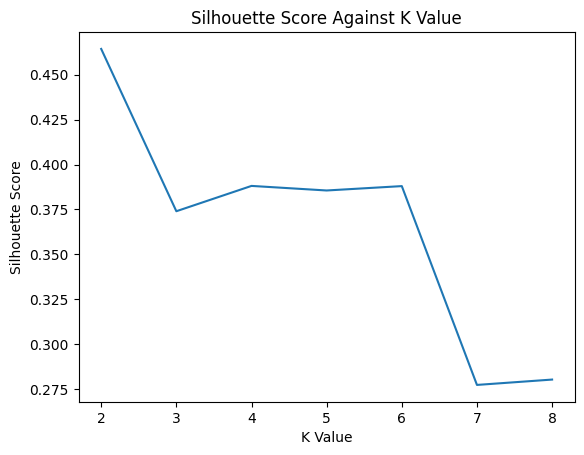

In [10]:
# Separating the airlines column from the features
airlines = data['airline']
x = data.loc[:, ~data.columns.isin(['airline'])]

# Scaling the feature data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_df = pd.DataFrame(x_scaled, columns=list(x.columns))

# Determine silhouette score
k_min = 2
k_max = 8
k_vals = range(k_min, k_max + 1)
sil_scores = []
for val in k_vals:
    k_clust = KMeans(n_clusters=val, n_init=10, random_state=5508)
    pred = k_clust.fit_predict(x_df)
    sil_scores.append(silhouette_score(x_df, pred))

# Plotting the silhouette scores
plt.plot(k_vals, sil_scores)
plt.title("Silhouette Score Against K Value")
plt.xlabel("K Value")
plt.ylabel("Silhouette Score")
plt.show()

The data is loaded in and the 'airline' feature removed as it acts essentially just like an identification variable. Scaling is then performed to ensure that the scale of the variables does not bias the dissimilarity measure by influencing the euclidean distance between different features/instances. The silhouette score is then determined. Here, scores range from -1 to 1, with a score of 1 corresponding to an instance being well matched to its own cluster and -1 to an instance matched to a different cluster. Hence, a higher score is better, as it indicates a better separation of clusters. 

Looking at the plot of silhouette score against k value, we can see that a k value of 6 would likely be a good choice. While the highest silhouette score is for k = 2, the drastic drop in score to k = 3 and beyond would indicate that this k = 2 value is falsely high. The plateau of silhouette scores between k = 3 and k = 6 indicates a good level of compactness and separation between clusters in this range. From k = 7 onwards, the drop from the plateau indicates too many clusters are now present and the separation between clusters is not as optimal. Hence, the best k value should be taken from the plateau, where k = 6 shows the highest silhouette score so is a good candidate.

> - **Task 2:** Apply K-means clustering with the value of K obtained in Task 1. Describe the main characteristic of each group, that is, provide the interpretation of the groups in terms of safety records. For the
K-means clustering, you should use the Euclidean distance and set random state to “5508”.

Cluster 1 centroid coordinates: [ 0.05 -0.04 -0.06 -0.41  0.08  1.57  2.54]
Cluster 2 centroid coordinates: [3.38 1.29 2.17 1.12 3.15 1.97 1.24]
Cluster 3 centroid coordinates: [-0.22 -0.37 -0.48 -0.55 -0.34 -0.54 -0.39]
Cluster 4 centroid coordinates: [-0.13  6.29  4.17  0.11  0.42  0.4   0.29]
Cluster 5 centroid coordinates: [-0.22 -0.    0.33  1.84 -0.25 -0.19 -0.05]
Cluster 6 centroid coordinates: [-0.15  0.57  0.71  0.53  0.77  1.57 -0.02]


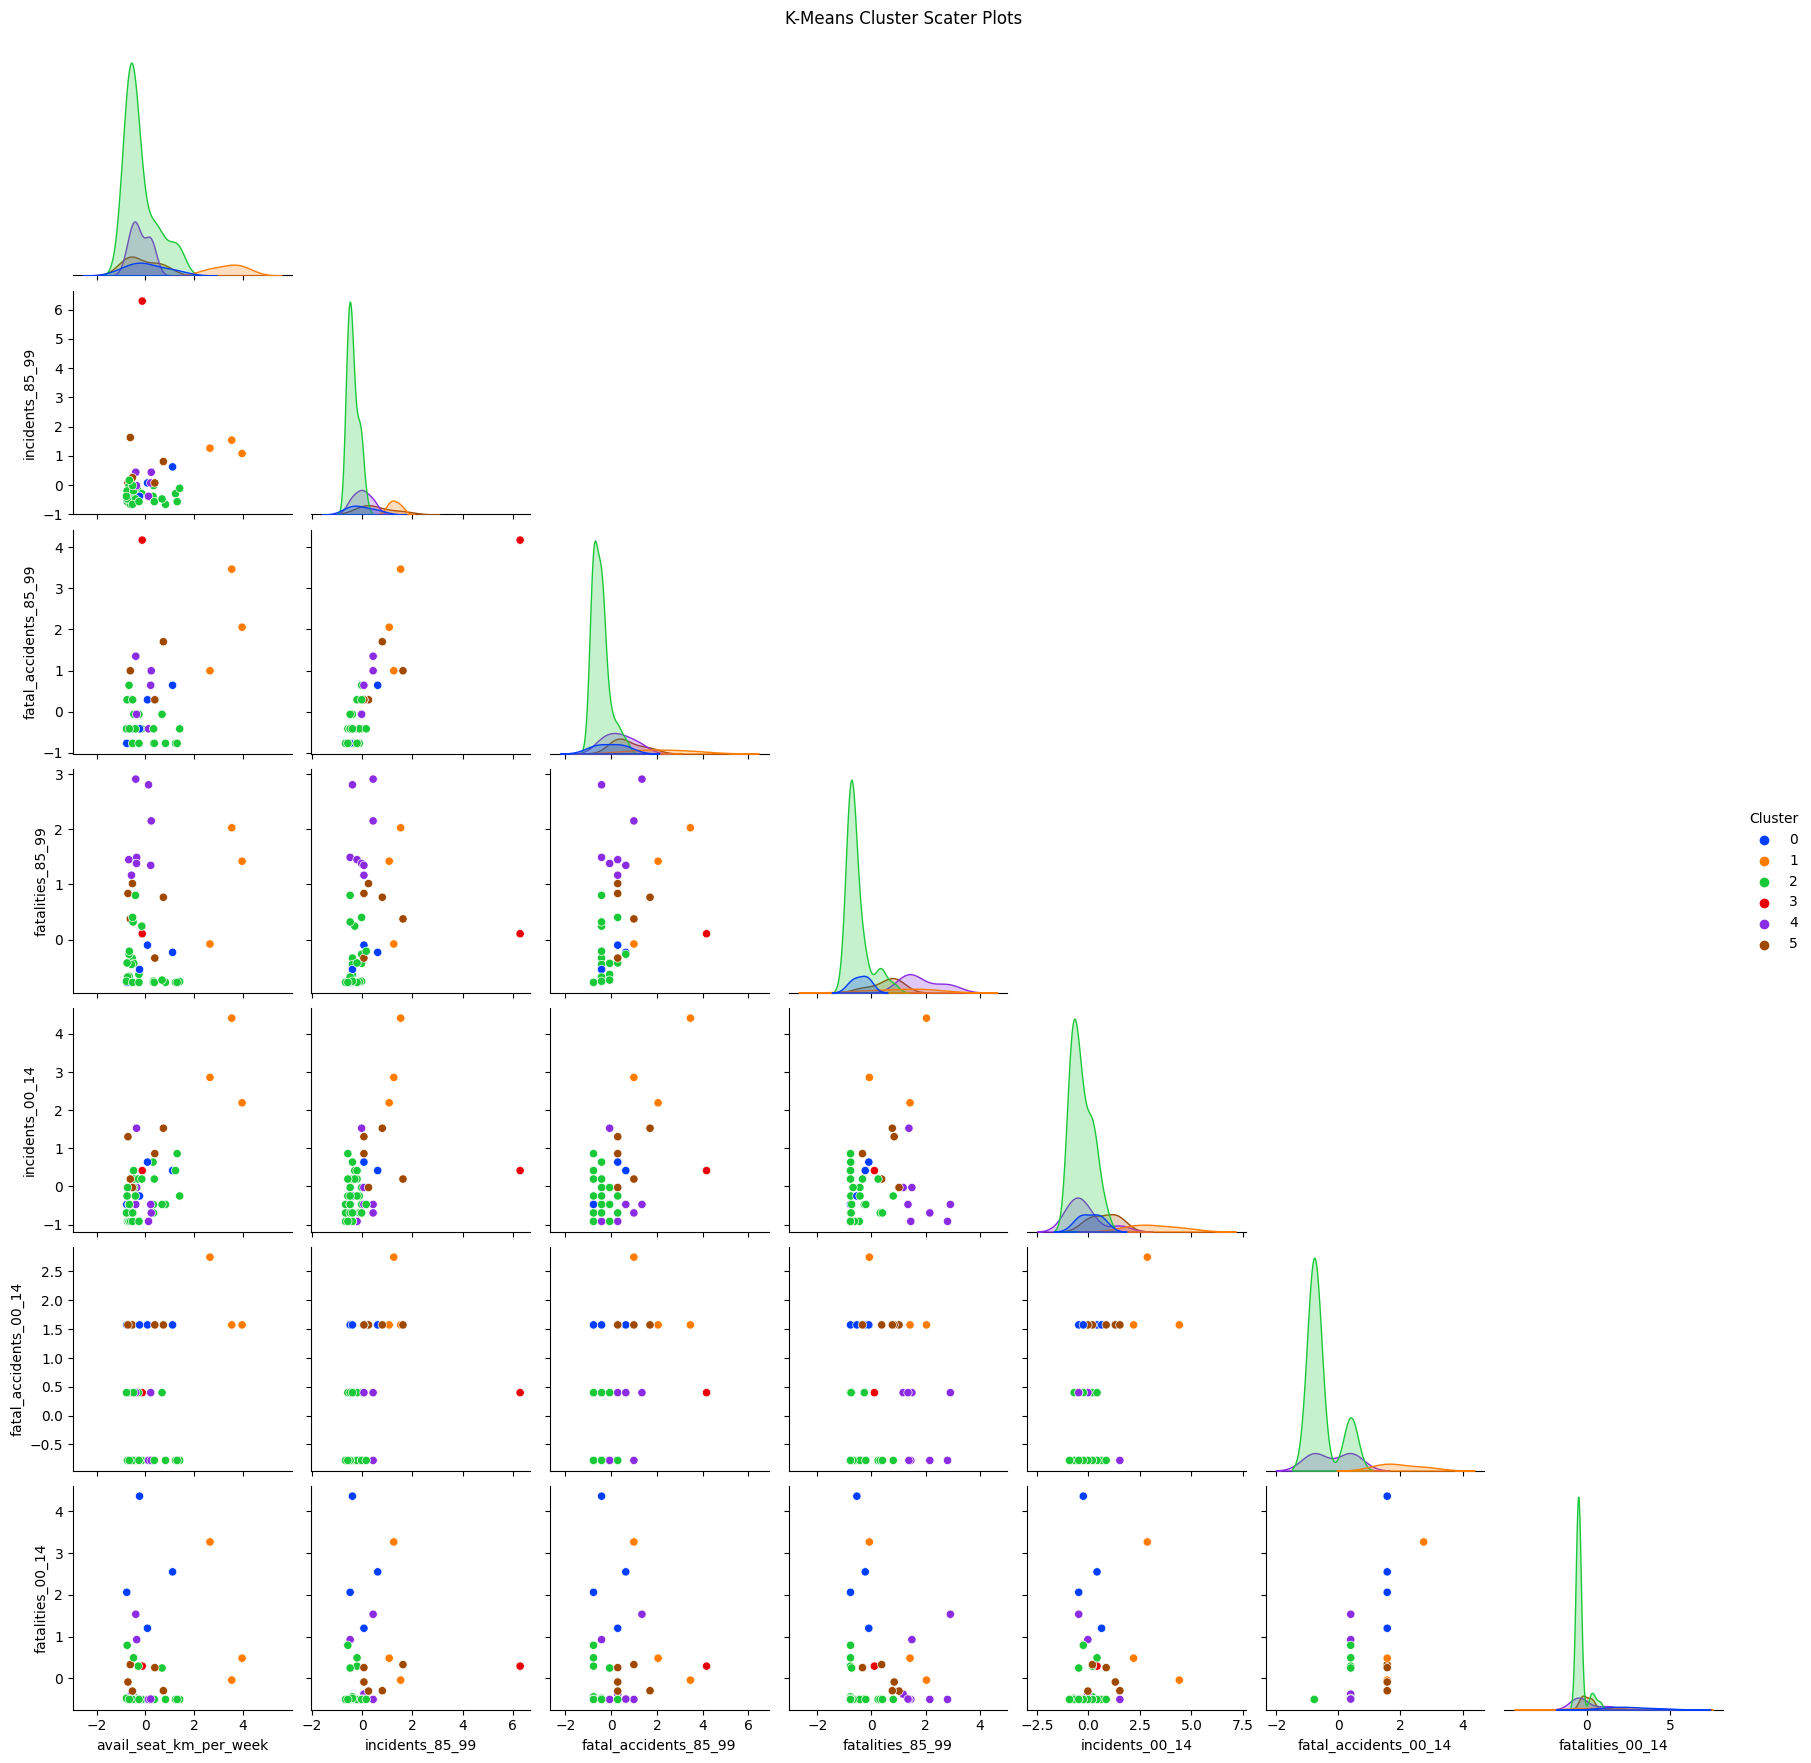

In [11]:
# Fit the k means clustering model and predict clusters
k_clust = KMeans(n_clusters=6, n_init=10, random_state=5508)
y = k_clust.fit_predict(x_df)
x_df['Cluster'] = y

# Returning cluster centroid coordinates
centroids = k_clust.cluster_centers_
k_vals = range(0, 6)
np.set_printoptions(precision=2, suppress=True)
for k in k_vals:
    print("Cluster {} centroid coordinates: {}".format(k + 1, centroids[k]))

# Plotting the clusters
k_clust_plot = sns.pairplot(x_df, hue='Cluster', palette='bright', corner=True)
k_clust_plot.fig.suptitle("K-Means Cluster Scater Plots", y=1.01)
plt.show()

From the centroid coordinates, the average value of the feature values/instances for each cluster can be seen. It is difficult to visualise these 7 dimensional points (a mild understatement), but the importance of each feature can be seen from the magnitude of each of the coordinate positions within these centroids. As this data has been scaled to a mean of 0 and unit standard deviation, we can expect clusters with coordinates significantly different from 0 to be influenced quite strongly by the corresponding feature. Hence, the feature importance on each cluster can be expressed by the magnitude of each feature's coordinate. Looking at the clusters, it can be seen that:
- Cluster 1: strongly influenced by features 6 and 7 ('fatal_accidents_00_14' and 'fatalities_00_14')
- Cluster 2: strongly influenced by features 1 and 5 ('avail_seat_km_per_week' and 'incidents_00_14')
- Cluster 3: not strongly influenced by any particular features
- Cluster 4: strongly influenced by features 2 and 3 ('incidents_85_99' and 'fatal_accidents_85_99')
- Cluster 5: strongly influenced by feature 4 ('fatalities_85_99')
- Cluster 6: strongly influenced by feature 6 ('fatal_accidents_00_14')

While I'm sure these clusters would be better displayed in a 7 dimensional plot, the collection of 2 dimensional scatter plots shows the clusters are not particularly distinctly separated in many cases (again, not assisted by not being in 7 dimensions). The shape of the clusters is also quite inconsistent, with no conclusions I am aware of being able to be drawn from them. 

> - **Task 3**: Explain your decision about scaling or not the data before running K-means (on Tasks 1 and 2),
and explain your decision about using or not all variables in the analysis.

Scaling was performed due to the difference in scales present in the original data. Any clustering would have been quite strongly impeded by the difference in scales, as the avail_seat_km_per_week feature varies by billions, whereas the other variables have ranges from 0 to the hundreds. Any measure of euclidean distance would be biased strongly by the difference in scale and result in much higher dissimilarity being assigned to clusters based off the features of higher magnitude scales. In order for each feature to be on the same scale and allow for a euclidean distance measure that does not more highly weight high magnitude scales, standard scaling was performed.

No variables were removed as a result of the feature importance explored in part 2 (too early to remove features in task 1 before this exploration). It can be seen in task 2 when examining the feature importance of each feature in the cluster centroid coordinates that all of the features were classed as important at some point to one or more of the clusters. Removing any feature would remove a feature important to one of the clusters and hence reduce its relevance to the data.

> - **Task 4:** Perform a K-means cluster analysis, considering the value of K from Task 1, and: (a) the three
variables from the years 1985-1999; (b) the three variables from the years 2000-2014. Did the clusters
change? Explain the results. For the K-means clustering, you should use the Euclidean distance and set
random state to “5508”

Cluster 1 (1900s) centroid coordinates: [-0.43 -0.6  -0.72]
Cluster 1 (2000s) centroid coordinates: [-0.69 -0.78 -0.5 ]

Cluster 2 (1900s) centroid coordinates: [1.26 1.84 0.9 ]
Cluster 2 (2000s) centroid coordinates: [0.96 1.57 0.23]

Cluster 3 (1900s) centroid coordinates: [6.29 4.17 0.11]
Cluster 3 (2000s) centroid coordinates: [-0.14  0.4   0.19]

Cluster 4 (1900s) centroid coordinates: [-0.08  0.11  1.19]
Cluster 4 (2000s) centroid coordinates: [0.64 1.87 3.06]

Cluster 5 (1900s) centroid coordinates: [-0.01  0.11 -0.1 ]
Cluster 5 (2000s) centroid coordinates: [ 0.44 -0.78 -0.5 ]

Cluster 6 (1900s) centroid coordinates: [0.17 0.64 2.62]
Cluster 6 (2000s) centroid coordinates: [ 4.41  1.57 -0.04]



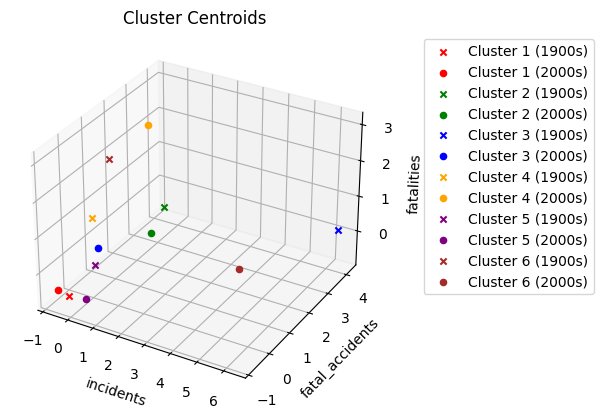

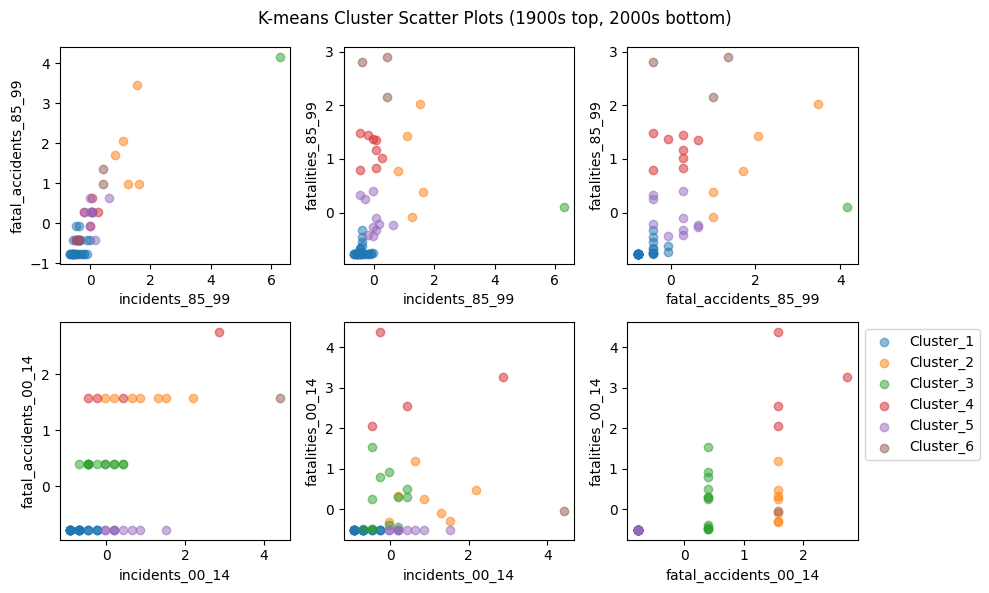

In [12]:
# Creating databases for the different years features
x_1900 = ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']
x_2000 = ['incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']
x_df_1900 = x_df[x_1900]
x_df_2000 = x_df[x_2000]

# Fit the k means clustering model for the different years
k_clust_1900 = KMeans(n_clusters=6, n_init=10, random_state=5508)
y_1900 = k_clust_1900.fit_predict(x_df_1900)
k_clust_2000 = KMeans(n_clusters=6, n_init=10, random_state=5508)
y_2000 = k_clust_2000.fit_predict(x_df_2000)

# Returning cluster centroid coordinates
centroids_1900 = k_clust_1900.cluster_centers_
centroids_2000 = k_clust_2000.cluster_centers_
k_vals = range(0, 6)
np.set_printoptions(precision=2, suppress=True)
for k in k_vals:
    print("Cluster {} (1900s) centroid coordinates: {}".format(k + 1, centroids_1900[k]))
    print("Cluster {} (2000s) centroid coordinates: {}\n".format(k + 1, centroids_2000[k]))

# Plot cluster centroids
ax = plt.axes(projection='3d')
k_vals = range(0, 6)
colours = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
for k in k_vals:
    ax.scatter3D(centroids_1900[k, 0], centroids_1900[k, 1], centroids_1900[k, 2], marker='x', 
                 color=colours[k], label='Cluster {} (1900s)'.format(k + 1))
    ax.scatter3D(centroids_2000[k, 0], centroids_2000[k, 1], centroids_2000[k, 2], marker='o', 
                 color=colours[k], label='Cluster {} (2000s)'.format(k + 1))
ax.set_title('Cluster Centroids')
ax.set_xlabel('incidents')
ax.set_ylabel('fatal_accidents')
ax.set_zlabel('fatalities')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

# Plot the clusters
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('K-means Cluster Scatter Plots (1900s top, 2000s bottom)')
clusters = range(0, 6)
for cluster in clusters:
    ax[0, 0].scatter(x_df_1900['incidents_85_99'][y_1900 == cluster], x_df_1900['fatal_accidents_85_99'][y_1900 == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[0, 0].set(xlabel='incidents_85_99', ylabel='fatal_accidents_85_99')
    ax[0, 1].scatter(x_df_1900['incidents_85_99'][y_1900 == cluster], x_df_1900['fatalities_85_99'][y_1900 == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[0, 1].set(xlabel='incidents_85_99', ylabel='fatalities_85_99')
    ax[0, 2].scatter(x_df_1900['fatal_accidents_85_99'][y_1900 == cluster], x_df_1900['fatalities_85_99'][y_1900 == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[0, 2].set(xlabel='fatal_accidents_85_99', ylabel='fatalities_85_99')
    ax[1, 0].scatter(x_df_2000['incidents_00_14'][y_2000 == cluster], x_df_2000['fatal_accidents_00_14'][y_2000 == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[1, 0].set(xlabel='incidents_00_14', ylabel='fatal_accidents_00_14')
    ax[1, 1].scatter(x_df_2000['incidents_00_14'][y_2000 == cluster], x_df_2000['fatalities_00_14'][y_2000 == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[1, 1].set(xlabel='incidents_00_14', ylabel='fatalities_00_14')
    ax[1, 2].scatter(x_df_2000['fatal_accidents_00_14'][y_2000 == cluster], x_df_2000['fatalities_00_14'][y_2000 == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[1, 2].set(xlabel='fatal_accidents_00_14', ylabel='fatalities_00_14')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

New k means models were created and fitted using just the relevant years data. Information regarding the centroids was determined and clusters plotted.

Looking at the coordinates of the clusters, it can be seen that there is quite a large charge in the cluster centroid coordinates for 3 of the 6 clusters when changing between the different years. Clusters 1, 2 and 5 do not show any large changes in their centroid positions, but cluster 3 shows less importance assigned to incidents and fatal accidents in the 2000s. Similarly, cluster 4 shows a heavier importance on fatal accidents in the 2000s and cluster 6 less importance on fatalities and more importance on incidents and fatal accidents in the 2000s.

This can be visually seen in the 3 dimensional plot of centroid coordinates, where clusteres 1, 2 and 5 do not move by a significant portion, while clusters 3, 4 and 6 move by quite a significant portion.

The shapes of 2 dimensional clusters can also be seen to change quite significantly when looking at the final subplot, with the 1900s data on the top and the 2000s data below it differing quite substantially.

It would appear that changing data from the 1900s to 2000s provides quite a subsantial effect on the clusters and their centroids.

>- **Task 5:** Consider three new features as the ratio of the variables from 2000-2014 divided by the respective variables from 1985-1999. Now, perform a K-means cluster analysis, considering the value of K
from Task 1. Present the results of this cluster analysis, and compare them with the results from Task 2
and Task 4. For the K-means clustering, you should use the Euclidean distance and set random state
to “5508”

Cluster 1 (ratios) centroid coordinates: [8.23 8.88 0.27]
Cluster 2 (ratios) centroid coordinates: [-93.48  12.33  -0.36]
Cluster 3 (ratios) centroid coordinates: [37.96 -0.06  0.43]
Cluster 4 (ratios) centroid coordinates: [  2.26   2.76 -41.62]
Cluster 5 (ratios) centroid coordinates: [0.56 0.63 0.28]
Cluster 6 (ratios) centroid coordinates: [  3.27   1.37 -10.43]


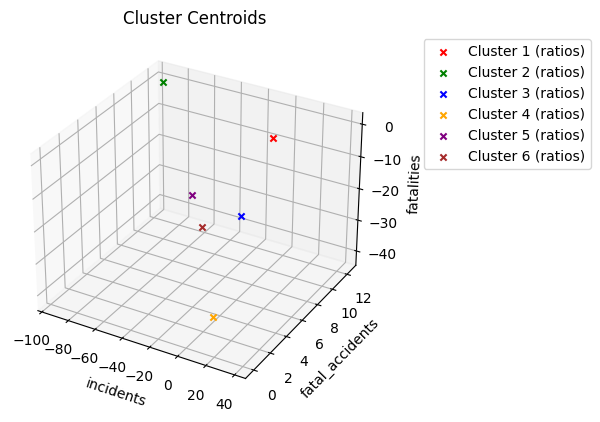

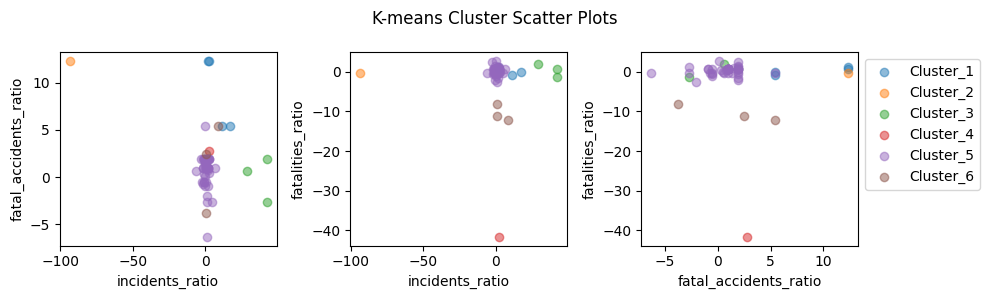

In [13]:
# Creating database for the ratio of 2000s/1900s
ratios = ['incidents_ratio', 'fatal_accidents_ratio', 'fatalities_ratio']
index = 0
while index < len(ratios):
    x_df[ratios[index]] = x_df_2000[x_2000[index]] / x_df_1900[x_1900[index]]
    index += 1
x_df_ratio = x_df[ratios]

# Fit the k means clustering model
k_clust_ratio = KMeans(n_clusters=6, n_init=10, random_state=5508)
y_ratio = k_clust_ratio.fit_predict(x_df_ratio)

# Returning cluster centroid coordinates
centroids_ratio = k_clust_ratio.cluster_centers_
k_vals = range(0, 6)
np.set_printoptions(precision=2, suppress=True)
for k in k_vals:
    print("Cluster {} (ratios) centroid coordinates: {}".format(k + 1, centroids_ratio[k]))

# Plot cluster centroids
ax = plt.axes(projection='3d')
k_vals = range(0, 6)
colours = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
for k in k_vals:
    ax.scatter3D(centroids_ratio[k, 0], centroids_ratio[k, 1], centroids_ratio[k, 2], marker='x', 
                 color=colours[k], label='Cluster {} (ratios)'.format(k + 1))
ax.set_title('Cluster Centroids')
ax.set_xlabel('incidents')
ax.set_ylabel('fatal_accidents')
ax.set_zlabel('fatalities')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

# Plot the clusters
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle('K-means Cluster Scatter Plots')
clusters = range(0, 6)
for cluster in clusters:
    ax[0].scatter(x_df_ratio['incidents_ratio'][y_ratio == cluster], x_df_ratio['fatal_accidents_ratio'][y_ratio == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[0].set(xlabel='incidents_ratio', ylabel='fatal_accidents_ratio')
    ax[1].scatter(x_df_ratio['incidents_ratio'][y_ratio == cluster], x_df_ratio['fatalities_ratio'][y_ratio == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[1].set(xlabel='incidents_ratio', ylabel='fatalities_ratio')
    ax[2].scatter(x_df_ratio['fatal_accidents_ratio'][y_ratio == cluster], x_df_ratio['fatalities_ratio'][y_ratio == cluster],
                     label='Cluster_{}'.format(cluster + 1), alpha=0.5)
    ax[2].set(xlabel='fatal_accidents_ratio', ylabel='fatalities_ratio')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Ratios of the different years data have been taken and k means analysis performed. The same analysis as in part 4 has then been conducted.

Looking at the coordinates of the centroids, it can be seen that the scale has changed quite substantially. This would be expected from the values present in the previous part. Looking at each individual cluster:
- Cluster 1: The ratios data now puts much greater importance on the incidents and fatal accidents features. In task 4, the importance allocations were fairly uniform between all 3 features. In task 2, the 2000s fatal accidents and fatalities were shown to be of strong importance.
- Cluster 2: The ratios data now puts much greater importance on the incidents and fatal accidents features. In task 4, the importance allocations were much the same in the 1900s but only really favoured the fatal accidents in the 2000s. In task 2, the 2000s fatalities were shown to be of strong importance.
- Cluster 3 The ratios data now puts much greater importance on the incidents feature. In task 4, the importance allocations favoured the incidents and fatal accidents in the 1900s and didn't favour any particular feature in the 2000s. In task 2, no particular feature was favoured.
- Cluster 4: The ratios data now puts much greater importance on the fatalities feature. In task 4, the importance allocations didn't favour any particular feature in the 1900s and favoured the fatal accidents and fatalities in the 2000s. In task 2, the incidents and fatal accidents in the 1900s were favoured.
- Cluster 5: The ratios data doesn't favour any feature particularly strongly. In task 4, much the same was observed, while in task 2, the 1900s fatalities were shown to be of the most importance.
- Cluster 6: The ratios data favours fatalities as the most important. In task 4, this was much the same in the 1900s but in the 2000s the other 2 features were of much greater importance. In task 2, the 2000s fatal accidents were of greater importance.

Looking at the 3 dimensional plot of cluster centroid coordinates, it can be seen that the centroids for all the clusters have shifted quite substantially when compared to task 4. The difference in scale also becomes quite apparent. The physical separation between these centroids also appears to be substantially larger, especially given the new scale employed.

Looking at the 2 dimensional scatter plots, it can be seen that the shapes of the clusters are also quite substantially different when compared to the corresponding plots in both task 4 and task 2. It can also be observed that the clusters appear more greatly separated than they did in the previous parts.

It can thus be seen that the change to the use of the year ratios can be used to potentially further separate the clusters, with the centroids appearing much more spread out and the clusters showing less overlap in comparison to task 4. The features of importance also seem to vary, with some clusters still allocating high importance to the features they did in tasks 4 and 2, though many clusters have completely reallocated importance between the features. It is hard to tell what features will remain important when switching between the three tasks. 

## 3.3 A clustering analysis on the US arrests data ##
> - **Task 1:** Using the raw data, perform a hierarchical clustering with complete linkage and Euclidean
distance to cluster the states. Cut the dendrogram at a height that results in three distinct clusters. Which
states belong to which cluster? Describe their characteristics.

In [14]:
# Creating df from csv
data_file = 'USArrests.csv'
data = pd.read_csv(data_file)

# Check for any NaN values
nan_check = data.isnull().values.any() 
print("Are NaN values present in the data set?\n{}".format(nan_check))

# Examine data
data.head(5)

Are NaN values present in the data set?
False


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


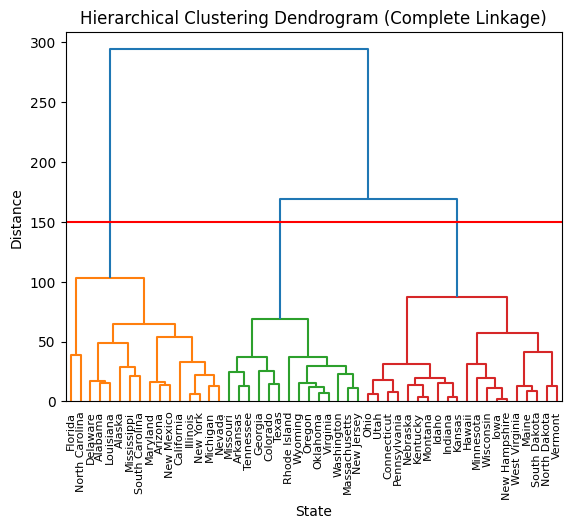

States in each cluster:


,Cluster_1,Cluster_2,Cluster_3
0,Alabama,Arkansas,Connecticut
1,Alaska,Colorado,Hawaii
2,Arizona,Georgia,Idaho
3,California,Massachusetts,Indiana
4,Delaware,Missouri,Iowa
5,Florida,New Jersey,Kansas
6,Illinois,Oklahoma,Kentucky
7,Louisiana,Oregon,Maine
8,Maryland,Rhode Island,Minnesota
9,Michigan,Tennessee,Montana


In [15]:
# Separating the states column from the features
states = data['State'].values.ravel()
x = data.loc[:, ~data.columns.isin(['State'])]

# Link clusters
x_linked = linkage(x, method='complete', metric='euclidean')

# Plot dendrogram
dendrogram(x_linked, labels=states, color_threshold=150)
plt.title("Hierarchical Clustering Dendrogram (Complete Linkage)")
plt.xlabel("State")
plt.ylabel("Distance")
plt.axhline(y=150, color="red")
plt.show()

# Sort states into each cluster
clusters = cut_tree(x_linked, n_clusters=3)
cluster_list = [[], [], []]
index = 0
while index < len(states):
    cluster_list[clusters[index][0]].append(states[index])
    index += 1

# Display clusters in dataframe
cluster_df = pd.DataFrame(cluster_list)
cluster_df = cluster_df.T
cluster_df = cluster_df.rename(columns={0: 'Cluster_1', 1: 'Cluster_2', 2: 'Cluster_3'})
print("States in each cluster:")
cluster_df

The data has been read in and the 'states' variable removed from the dataset initially as it acts effectively as an identification variable. It should not be used as a feature variable. Hierarchical clustering has then been performed using complete linkage such that the distance between the two furthest points in each cluster is used to determine the dissimilarity between the clusters. An initial data point is selected and the closest point to it is taken as the least dissimilar instance, hence the two are formed into a cluster. Then find the next cluster (which may be an individual instance or a group of instances) with the shortest distance between the two instances with greatest separation in the two clusters and merge these two clusters together. This is continued until only one clusters remains (as is the case here) or a specified number of clusters has been reached. This method does tend to produce more compact, spherical clusters as a result of trying to minimise the maximum distance between instances in the different clusters, making it less sensitive to outliers but more prone to chaining.

Euclidean distance has been used in the hierarchical clustering to determine the distance between the instances. It works by simply taking a straight line between 2 instances in multi-dimensional space and then using the length of said line as a measure of dissimilarity.

Looking at the dendrogram, we see that we get 3 clusters emerging around a distance of 105 (line taken at 150 for clarity). From the coloured clusters, we see that each of the 3 clusters appears to be somewhat similar in size. This is supported by the table of states in each cluster, which shows that all clusters have between 14 and 20 states contained within them. Additionally, we see that after these 3 clusters have formed, there is quite a large increase in distance before forming into 2 or 1 clusters, indicating a much larger increase in dissimilarity between the clusters. This would indicate 3 clusters being a fairly natural place at which to stop clustering.

The states belong to each cluster can be seen in the table. Again, from the table it can be seen that each of the clusters is of a reasonably similar size. From the dendrogram, we can see that each of the clusters is also of a reasonably similar shape, being reasonably compact and with reasonably low merge heights, indicating a level of similarity between the clusters being merged within it. The branch lengths in each of the clusters mirrors this, being reasonably short and indicative of a good level of similarity (at least compared to when merging to only 1 or 2 total clusters).

> - **Task 2:** Repeat Task 1 after scaling the variables to have zero mean and unit standard deviation. What
effect does scaling the variables have on the hierarchical clustering obtained? In your opinion, should
the variables be scaled? Justify for your answer.

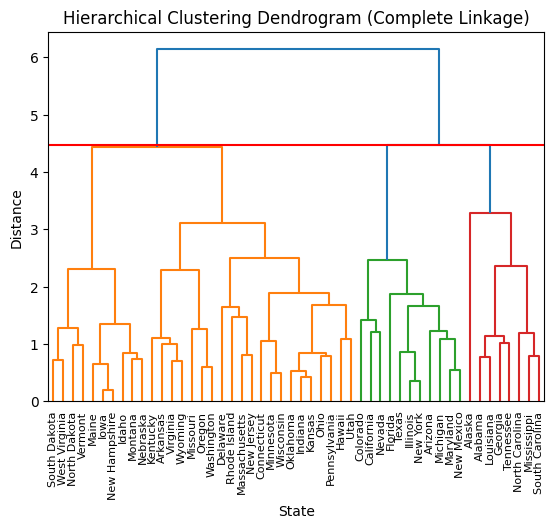

States in each cluster:


,Cluster_1,Cluster_2,Cluster_3
0,Alabama,Arizona,Arkansas
1,Alaska,California,Connecticut
2,Georgia,Colorado,Delaware
3,Louisiana,Florida,Hawaii
4,Mississippi,Illinois,Idaho
5,North Carolina,Maryland,Indiana
6,South Carolina,Michigan,Iowa
7,Tennessee,Nevada,Kansas
8,None,New Mexico,Kentucky
9,None,New York,Maine


In [16]:
# Scaling the feature data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled, columns=list(x.columns))

# Link clusters
x_linked = linkage(x, method='complete', metric='euclidean')

# Plot dendrogram
dendrogram(x_linked, labels=states, color_threshold=4.45)
plt.title("Hierarchical Clustering Dendrogram (Complete Linkage)")
plt.xlabel("State")
plt.ylabel("Distance")
plt.axhline(y=4.47, color="red")
plt.show()

# Sort states into each cluster
clusters = cut_tree(x_linked, n_clusters=3)
cluster_list = [[], [], []]
index = 0
while index < len(states):
    cluster_list[clusters[index][0]].append(states[index])
    index += 1

# Display clusters in dataframe
cluster_df = pd.DataFrame(cluster_list)
cluster_df = cluster_df.T
cluster_df = cluster_df.rename(columns={0: 'Cluster_1', 1: 'Cluster_2', 2: 'Cluster_3'})
print("States in each cluster:")
cluster_df

Scaling has been performed using sklearn's standard scaler as to establish a mean of zero and unit standard deviation. Clustering has then taken place in a similar manner as the previous part.

Looking at the dendrogram, we see that we get 3 clusters emerging around a distance of about 4.5. From the coloured clusters, we see that each of the 3 clusters no longer appear to be similar in size, with the orange cluster dominating and the red and green clusters being of a much smaller size in comparison. These two clusters are of reasonably similar size to one another, however. This is supported by the table of states in each cluster, which shows the largest cluster to have an overwhelming 31 of the 50 states present, while the two smaller clusters only have 8 and 11 clusters each. Looking at the distances at which the clusters are merged, we also notice that the scale is much smaller than in the previous part as a result of the scaling. Again looking at the distances at which the clusters are merged, we no longer see that 3 clusters appears to be the most optimal number of clusters formed, as the distance increase appears to be quite substantial in forming the orange cluster. 4 clusters would look like a more optimal choice, as the increase in merge height is much lower in the case of 4 clusters where the orange cluster is split into 2.

The states belong to each cluster can be seen in the table. Again, from the table it can be seen that there is quite a disparity in cluster size. From the dendrogram, we can see that the shape of the clusters varies somewhat from the previous part, appearing to exhibit a greater relative vertical height (less compact) than the unscaled case. This likely results from the difference in scales of the data no longer having an effect on the distances between clusters and emphasising some features over others due to their relative scale effecting the euclidean distance between clusters and hence dissimilarity. The red and green clusters especially show a more vertical shape, with the orange cluster appearing wider (although if split into its 2 smaller clusters than these do appear more vertical).

The branch lengths appear longer in general, especially at the lower distances, than in the case of the unscaled dendrogram. This is a result of higher relative dissimilarity being present as a result of scaling removing the bias established by the previous difference in scales. The increase in branch length also appears to occur for 4 clusters, rather than 3, which seems indicative that 4 clusters would be a more natural stopping point than 3 (as was the case in the previous part). This would also give a more similar size between each of the 4 clusters, with one cluster no longer dominating.

I believe the variables should be scaled as to remove the influence of the different feature scales and establish a fairer euclidean distance measure between instances less biased by the magnitude at which they were measured. Larger scales are likely to result in higher euclidean distances and hence dissimilarity measures than features of a smaller scale, hence biasing the clustering based off the scale of the different features present. The more consistent overall branch length on the scaled dendrogram makes me further think this, as we don't get such an extreme difference between 3/2/1 clusters (as seen in the unscaled case) as would not be intuitively expected.

> - **Task 3:** Perform PCA on the data. Now perform hierarchical clustering with complete linkage and
Euclidean distance on the first two principal component score vectors rather than the raw data. Cut
the dendrogram at a height that results in three distinct clusters. Present the scatterplot of the first two
principal components using different colours for the instances on each cluster (three colours for three
clusters). Compare the group characteristics to the group characteristics obtained in Task 2.

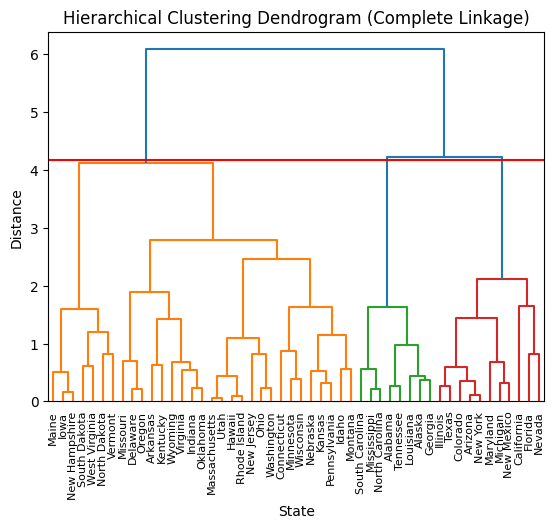

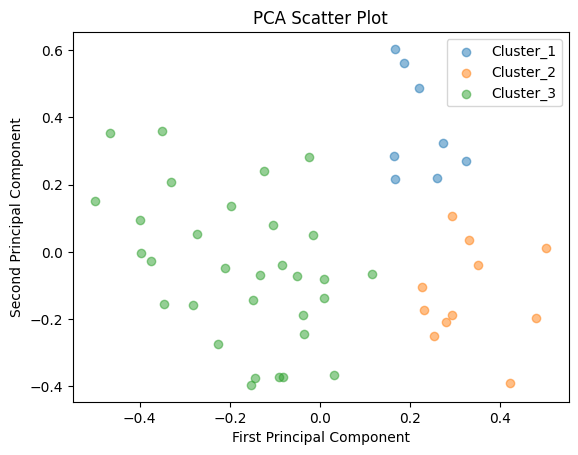

In [17]:
# Perform PCA fit and transform
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

# Separate into first and second principal components
PC1 = x_pca[:,0]
PC2 = x_pca[:,1]

# Set scale of principal components
PC1_scale = 1 / (max(PC1) - min(PC1))
PC2_scale = 1 / (max(PC2) - min(PC2))

# Form database of principal components and their labels
zipped = list(zip(PC1 * PC1_scale, PC2 * PC2_scale, states))
pc_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'states'])

# Link clusters
x_linked = linkage(x_pca, method='complete', metric='euclidean')

# Plot dendrogram
dendrogram(x_linked, labels=states, color_threshold=4.18)
plt.title("Hierarchical Clustering Dendrogram (Complete Linkage)")
plt.xlabel("State")
plt.ylabel("Distance")
plt.axhline(y=4.18, color="red")
plt.show()

# Sort states into each cluster
clusters = cut_tree(x_linked, n_clusters=3)
cluster_list = [[], [], []]
index = 0
while index < len(states):
    cluster_list[clusters[index][0]].append(states[index])
    index += 1

# Display clusters in dataframe
cluster_df = pd.DataFrame(cluster_list)
cluster_df = cluster_df.T
cluster_df = cluster_df.rename(columns={0: 'Cluster_1', 1: 'Cluster_2', 2: 'Cluster_3'})

# Creating dataframe to associate principal components with their clusters
state_cluster = []
for state in states:
    state_in_cluster = cluster_df.columns[cluster_df.eq(state).any()]
    state_cluster.append(state_in_cluster[0])
pc_df["Cluster"] = state_cluster

# Split into benign and malignant portions of principal components
PC1_c1 = pc_df.loc[pc_df["Cluster"] == "Cluster_1", "PC1"]
PC2_c1 = pc_df.loc[pc_df["Cluster"] == "Cluster_1", "PC2"]
PC1_c2 = pc_df.loc[pc_df["Cluster"] == "Cluster_2", "PC1"]
PC2_c2 = pc_df.loc[pc_df["Cluster"] == "Cluster_2", "PC2"]
PC1_c3 = pc_df.loc[pc_df["Cluster"] == "Cluster_3", "PC1"]
PC2_c3 = pc_df.loc[pc_df["Cluster"] == "Cluster_3", "PC2"]

# Produce PCA scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(PC1_c1, PC2_c1, label="Cluster_1", alpha=0.5)
ax.scatter(PC1_c2, PC2_c2, label="Cluster_2", alpha=0.5)
ax.scatter(PC1_c3, PC2_c3, label="Cluster_3", alpha=0.5)
ax.legend()
plt.title("PCA Scatter Plot")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

PCA has been performed to retain the two principal components using the scaled data created in the previous part, in line with the belief that this scaled data reduces bias created by differences in feature scales. The principal components have also been scaled using the min/max values to ensure they are on the same scale for clustering. Hierarchical clustering has then been performed in much the same fashion as was done in the previous 2 parts and a dendrogram produced, as well as a scatter plot showing the 3 clusters present when plotting the 2 principal components against one another. 

Looking at the group characteristics between this and the previous part, it can be seen that each of the groups remains fairly similar. The orange group maintains quite a large relative size, while the green and red clusters remain much smaller and of a similar size to one another. That being said, the red cluster is now slightly larger (3 states) than in the previous part and the green cluster 3 states smaller. The orange cluster retains the same number of states. The height at which the 3 clusters has formed is also reasonably similar, albeit it slightly lower than in the previous case, dropping from about 4.5 to 4.2, indicating a slight drop in dissimilarity. This is to be expected, as by only taking the first two principal components, not all of the variance has been explained (data has been lost) which could be used to further differentiate between the clusters. We see that the branch length remains reasonably similar to the last part and again may indicate that 4 clusters would be a better point to cease clustering as the increase in branch length after this point is quite substantial. The shape of the clusters again remains similar to the previous part, with the two smaller clusters remaining quite vertical and the larger cluster appearing to have a much stronger horizontal component compared to its vertical length.

Looking at the scatter plot, it can be seen that the 3 clusters are quite distinct, with a reasonably strong degree of separation between them. There are no points of overlap between the clusters. It can again be seen that the largest cluster (green in this case) dominates, and appears to be very correlated to a low first principal component value. The two smaller clusters both appear to exist in the region of higher first principal component values, then being separated by the second principal component value (one existing in the high region and the other in the low). It can also be seen that each of the clusters is somewhat spherical in nature, as would be expected from the complete linkage clustering.

> - **Task 4:** Repeat the analysis of Task 3 using the K-means clustering (with K=3). That is, use the first
two principal components score vectors as features and set the initial centroids of the K-means as the
group means obtained from the hierarchical clustering on Task 3. Compare the results from the Kmeans clustering to the results from the hierarchical clustering of Task 3. Which one do you think
provides a better result? For the K-means clustering, you should use the Euclidean distance and set
random state to “5508”.

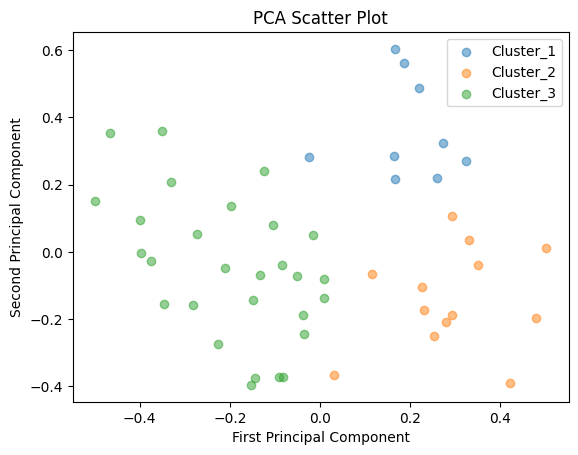

In [18]:
# Determine the centre of each cluster
c1_centre = [np.average(PC1_c1), np.average(PC2_c1)]
c2_centre = [np.average(PC1_c2), np.average(PC2_c2)]
c3_centre = [np.average(PC1_c3), np.average(PC2_c3)]
clust_centroids = [c1_centre, c2_centre, c3_centre]

# Form database of principal components
zipped = list(zip(PC1 * PC1_scale, PC2 * PC2_scale))
pc_df = pd.DataFrame(zipped, columns=['PC1', 'PC2'])

# Fit the k means clustering model
k_clust = KMeans(n_clusters=3, init=clust_centroids, n_init=1, random_state=5508)
k_clust.fit(pc_df)

# Add the cluster labels to the principal components dataframe
pc_df["Cluster"] = k_clust.labels_

# Split into benign and malignant portions of principal components
PC1_c1 = pc_df.loc[pc_df["Cluster"] == 0, "PC1"]
PC2_c1 = pc_df.loc[pc_df["Cluster"] == 0, "PC2"]
PC1_c2 = pc_df.loc[pc_df["Cluster"] == 1, "PC1"]
PC2_c2 = pc_df.loc[pc_df["Cluster"] == 1, "PC2"]
PC1_c3 = pc_df.loc[pc_df["Cluster"] == 2, "PC1"]
PC2_c3 = pc_df.loc[pc_df["Cluster"] == 2, "PC2"]

# Produce PCA scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(PC1_c1, PC2_c1, label="Cluster_1", alpha=0.5)
ax.scatter(PC1_c2, PC2_c2, label="Cluster_2", alpha=0.5)
ax.scatter(PC1_c3, PC2_c3, label="Cluster_3", alpha=0.5)
ax.legend()
plt.title("PCA Scatter Plot")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

The cluster centres have been taken from the previous part and used as the initial centroids for the k means clustering. This should in theory give reasonably similar clusters, with the centre instances being much the same and the only likely difference occuring at the edges of the clusters. This comes as a result of the complete linkage hierarchical clustering method looking to minimise the maximum distance between clusters, while the k means clustering method instead aims to minimise the variation within the cluster by assigning instances to a cluster based off their nearest centroid.

Looking at the scatter plot produced, we can see that it looks largely the same as in the previous part, but with 3 of the outer instances of cluster_3 being assigned to the other clusters (2 instances to cluster_2 and 1 to cluster_1). The shapes of the clusters remain largely the same and so does the positioning and distances of the clusters relative to one anohter. The only change is in the 3 cluster_3 instances assigned to the other 2 clusters.

I would say that the hierarchical clustering method provides the better result, as the shapes of the clusters present using this method are more compact/distinct. The instances that have been classified instead as belonging to the smaller clusters in the k means method appear to be closer to the larger cluster and drop the instance density of the smaller clusters, which may indicate that they would better belong with the large cluster, as was the case in hierarchical clustering.